In [53]:
import numpy as np
import pandas as pd
import warnings
import requests
import random
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
index = ['BIOTECH', 'HAZWST','BLDTOT', 'PTETHR', 'FLPTHR', 'SPPASS', 'AMTHR','SPPTOT']

Import of all needed data

In [55]:
url_CSV = 'https://github.com/LanceryH/NASA-hackathon-2024/raw/refs/heads/main/data_SEDAC.csv'
url_JSON = 'https://github.com/LanceryH/NASA-hackathon-2024/raw/refs/heads/main/country_continent.json'
data_brut = pd.read_csv(url_CSV, encoding='ISO-8859-1')
data_class_country = requests.get(url_JSON).json()

Rearrange the dataset to match our needs

In [56]:
data_SEDAC = data_brut.pivot_table(index=None,
                                   columns='Country_Standard',
                                   values=index,
                                   aggfunc='first')

data_SEDAC = data_SEDAC.replace(" ", 0, regex=True)
data_SEDAC.columns = data_SEDAC.columns.map(data_class_country)

Creates values that will contains part of the dataset

In [58]:
labels_columns = data_SEDAC.columns.to_numpy()
labels_row = data_SEDAC.index.to_numpy()
R = data_SEDAC.to_numpy().astype("float").T

Lets first define all basic mathematic definition

In [59]:
def Esperance(X):  # Calcul l'Esperance de X
    m = np.shape(X)[0]
    return(np.sum(X)/m)

def Variance(X):  # Calcul la Variance de X
    m = np.shape(X)[0]
    return(np.sum(((X-Esperance(X))**2)/(m-1)))

def centre_red(R):  # Calcul de la matrice centrée réduite de R
    m, n = np.shape(R)  # shape de la matrice d'entrée
    Rcr = np.zeros((m, n))  # matrice de zéros de taille (m,n)
    for i in range(n):
        Xa = R[:, i]  # Récupère la colonne de R
        # calcul de chaque colonne de la futur matrice centrée réduite
        Rcr[:, i] = (Xa-Esperance(Xa)) / np.sqrt(Variance(Xa))
    return (Rcr)

def approx(R, k):  # Calcul l'Esperance
    X = centre_red(R)  # On centre réduit notre matrice d'entrée
    m, n = np.shape(X)  # on stock la forme m,n de la matrice centrée reduite
    u, s, vt = np.linalg.svd(X)
    v = vt.T  # transpose vt
    projk = []
    for i in range(k):
        vk = v[:, i].reshape(len(v), 1)  # on récupère vk la colonne i de v
        Yk = X@vk  # on calcul Yk avec X et vk
        uj = u[:, i].reshape(len(u), 1)  # on récupère uj la colonne i de u
        # on insert dans projk la variance de Yk*uj
        projk.insert(i, Variance(Yk)*uj)
    # on utilise np.block pour construire notre matrice finale projk
    projk = np.block([projk[i] for i in range(k)])
    return(projk)


def Covariance(X, Y):  # Calcul de la Covariance de X avec Y
    m = np.shape(X)[0]
    return(np.sum((X-Esperance(X))*(Y-Esperance(Y)))*(1/m))

def correlation(X, Y):  # Fonction de Corélation entre deux matrices de même taille
    Cori = []
    m, n = np.shape(X)  # on stock la forme m,n de la matrice centrée reduite X
    for i in range(n):
        # Calcul de la corélation entre Y1 et Xi avec i variant de 0 à n-1
        Corik = Covariance(X[:, i], Y) / (Variance(X[:, i])*Variance(Y)) ** 0.5
        Cori.insert(i, Corik)  # on stock le résultat
    # la fonction est déjà en transposée
    return(Cori)

def correlationdirprinc(R, k):  # Ensemble des corélation de Yk et Xi
    X = centre_red(R)
    Y = approx(X, k)
    Cori = []
    for i in range(k):
        # on applique la fonction Cori sur X et la colonne i de Y
        Corik = correlation(X, Y[:, i])
        Cori.insert(i, Corik)  # On stock le résultat final
    return (Cori)

In [65]:
X = centre_red(R)
u, s, vt = np.linalg.svd(X)
m, k = X.shape
explained_variance = (s**2) / np.sum(s**2)  # Calculate explained variance


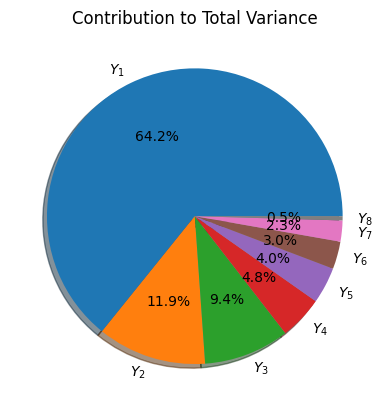

In [69]:
ind = [f'$Y_{i+1}$' for i in range(k)]  # Principal component labels

plt.figure()
plt.pie(explained_variance, labels=ind, autopct='%.1f%%', shadow=True)
plt.title('Contribution to Total Variance')
plt.show()

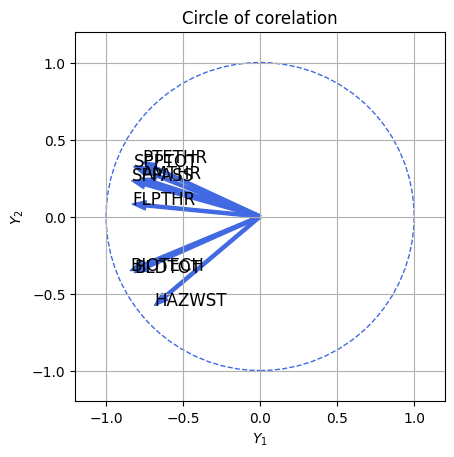

In [71]:
Corx = correlationdirprinc(R, 2)[0]
Cory = correlationdirprinc(R, 2)[1]
# Tracé des flèches et de leur label
fig, ax = plt.subplots()
plt.grid()
plt.title('Circle of corelation')
plt.xlabel('$Y_{1}$')
plt.ylabel('$Y_{2}$')
draw_circle = plt.Circle((0.0, 0.0), 1.0, fill=False, ls='--', color='royalblue')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
ax.add_artist(draw_circle)
ax.set_aspect(1)
for i in range(np.shape(R)[1]):
    plt.arrow(0, 0, Corx[i], Cory[i], width=0.02,
              length_includes_head=True, color='royalblue')
    plt.annotate(text=labels_row[i], xy=(
        Corx[i], Cory[i]),  fontsize=12)

plt.show()

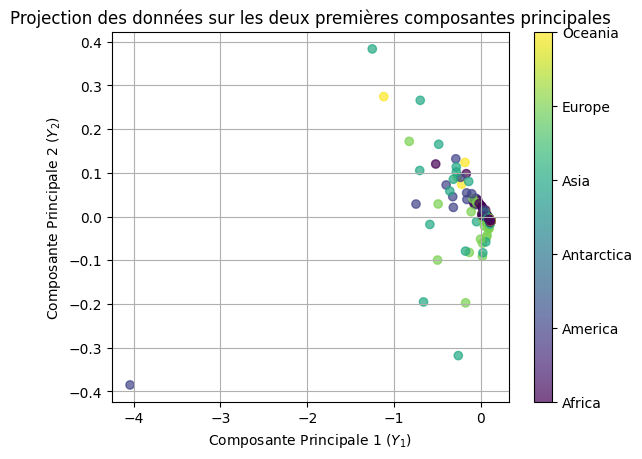

In [73]:
Y = approx(X, 2)

# Encoder les labels en numéros si ce sont des catégories textuelles
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_columns)
# Tracé des données projetées dans l'espace des composantes principales
plt.figure()
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)
plt.xlabel('Composante Principale 1 ($Y_1$)')
plt.ylabel('Composante Principale 2 ($Y_2$)')
plt.title('Projection des données sur les deux premières composantes principales')
plt.grid(True)
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)  # Afficher les labels originaux dans la barre de couleur
plt.show()

In [62]:
from sklearn.manifold import TSNE

def TSNE2D_plot(R, labels_row, labels_columns):
    # Centrer et réduire la matrice R
    X = centre_red(R)

    # Appliquer t-SNE pour une réduction de dimensions non linéaire
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    Y_tsne = tsne.fit_transform(X)

    # Encoder les labels en numéros si ce sont des catégories textuelles
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_columns)

    # Tracé en 2D des données projetées
    plt.figure()
    scatter = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)

    # Annoter le graphique
    plt.xlabel('$tSNE_1$')
    plt.ylabel('$tSNE_2$')
    plt.title('Projection des données en 2D avec t-SNE')
    plt.grid(True)

    # Ajouter une barre de couleurs
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)

    plt.show()

# Utilisation de la fonction
# TSNE2D_plot(R, labels_row)


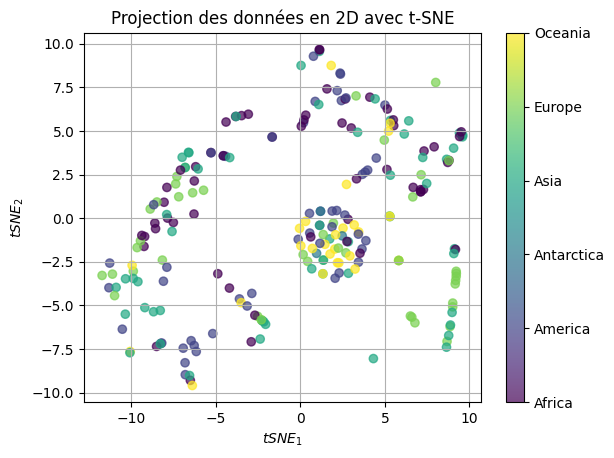

In [63]:
TSNE2D_plot(R, labels_row, labels_columns)